# 2. 없다면 어떻게 될까? (ResNet Ablation Study)

|평가문항|상세기준|
|---|---|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

In [31]:
import tensorflow as tf
import keras
import numpy as np
import tensorflow_datasets as tfds

In [2]:
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}')(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}')(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [3]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i)    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output)
    return model

In [4]:
resnet_34_plain = build_resnet(input_shape=(32, 32,3), is_50=False, is_plain=True)
resnet_34_plain.summary()

2023-05-23 21:31:44.810435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 21:31:44.846373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 21:31:44.846422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 21:31:44.847866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 21:31:44.847940: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   832         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['batch_normalization[0][0]']

In [5]:
resnet_34_res = build_resnet(input_shape=(32, 32,3), is_50=False, is_plain=False)
resnet_34_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 64)   832         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 16, 16, 64)  256         ['conv2d_4[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_17[0]

In [6]:
resnet_50_plain = build_resnet(input_shape=(32, 32,3), is_50=True, is_plain=True)
resnet_50_plain.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 64)   832         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 16, 16, 64)  256         ['conv2d_8[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_34[0]

In [7]:
resnet_50_res = build_resnet(input_shape=(32, 32,3), is_50=True, is_plain=False)
resnet_50_res.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 16, 16, 64)   832         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_51 (BatchN  (None, 16, 16, 64)  256         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_51[0]

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
BATCH_SIZE = 64
EPOCH = 15

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/home/gibeom/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title =

In [11]:
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet_34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


2023-05-23 21:31:48.356396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-23 21:31:48.356788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-23 21:31:55.692380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801
2023-05-23 21:31:56.934655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-23 21:31:5

781/781 [==============================] - ETA: 0s - loss: 2.0563 - accuracy: 0.3457

2023-05-23 21:32:41.371548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-23 21:32:41.371957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


781/781 [==============================] - 57s 57ms/step - loss: 2.0563 - accuracy: 0.3457 - val_loss: 1.7628 - val_accuracy: 0.4148
Epoch 2/15
781/781 [==============================] - 44s 56ms/step - loss: 1.5606 - accuracy: 0.4618 - val_loss: 1.4085 - val_accuracy: 0.5033
Epoch 3/15
781/781 [==============================] - 44s 57ms/step - loss: 1.3297 - accuracy: 0.5350 - val_loss: 1.5118 - val_accuracy: 0.4904
Epoch 4/15
781/781 [==============================] - 42s 53ms/step - loss: 1.1627 - accuracy: 0.5878 - val_loss: 1.4365 - val_accuracy: 0.5188
Epoch 5/15
781/781 [==============================] - 42s 54ms/step - loss: 1.0156 - accuracy: 0.6411 - val_loss: 1.3144 - val_accuracy: 0.5651
Epoch 6/15
781/781 [==============================] - 42s 54ms/step - loss: 0.8760 - accuracy: 0.6895 - val_loss: 1.4236 - val_accuracy: 0.5442
Epoch 7/15
781/781 [==============================] - 42s 54ms/step - loss: 0.7393 - accuracy: 0.7388 - val_loss: 1.5367 - val_accuracy: 0.5363
Epo

In [12]:
resnet_34_res.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_res = resnet_34_res.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
781/781 [==============================] - 51s 55ms/step - loss: 2.0195 - accuracy: 0.3468 - val_loss: 1.7716 - val_accuracy: 0.3969
Epoch 2/15
781/781 [==============================] - 43s 55ms/step - loss: 1.5267 - accuracy: 0.4696 - val_loss: 1.6204 - val_accuracy: 0.4572
Epoch 3/15
781/781 [==============================] - 42s 54ms/step - loss: 1.3128 - accuracy: 0.5378 - val_loss: 1.4510 - val_accuracy: 0.5025
Epoch 4/15
781/781 [==============================] - 41s 53ms/step - loss: 1.1493 - accuracy: 0.5908 - val_loss: 1.3242 - val_accuracy: 0.5442
Epoch 5/15
781/781 [==============================] - 44s 56ms/step - loss: 1.0057 - accuracy: 0.6426 - val_loss: 1.3175 - val_accuracy: 0.5535
Epoch 6/15
781/781 [==============================] - 45s 57ms/step - loss: 0.8700 - accuracy: 0.6905 - val_loss: 1.3363 - val_accuracy: 0.5628
Epoch 7/15
781/781 [==============================] - 41s 53ms/step - loss: 0.7343 - accuracy: 0.7408 - val_loss: 1.3323 - val_accuracy:

In [13]:
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet_50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
781/781 [==============================] - 49s 53ms/step - loss: 2.0805 - accuracy: 0.3381 - val_loss: 1.8864 - val_accuracy: 0.3802
Epoch 2/15
781/781 [==============================] - 43s 56ms/step - loss: 1.5584 - accuracy: 0.4644 - val_loss: 2.0272 - val_accuracy: 0.3679
Epoch 3/15
781/781 [==============================] - 43s 55ms/step - loss: 1.3433 - accuracy: 0.5279 - val_loss: 1.5236 - val_accuracy: 0.4910
Epoch 4/15
781/781 [==============================] - 43s 55ms/step - loss: 1.1746 - accuracy: 0.5857 - val_loss: 1.5734 - val_accuracy: 0.4899
Epoch 5/15
781/781 [==============================] - 42s 54ms/step - loss: 1.0204 - accuracy: 0.6370 - val_loss: 1.2854 - val_accuracy: 0.5626
Epoch 6/15
781/781 [==============================] - 43s 55ms/step - loss: 0.8841 - accuracy: 0.6864 - val_loss: 1.3310 - val_accuracy: 0.5578
Epoch 7/15
781/781 [==============================] - 44s 56ms/step - loss: 0.7439 - accuracy: 0.7383 - val_loss: 1.4324 - val_accuracy:

In [14]:
resnet_50_res.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_res = resnet_50_res.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
781/781 [==============================] - 52s 56ms/step - loss: 2.0262 - accuracy: 0.3497 - val_loss: 2.2470 - val_accuracy: 0.2942
Epoch 2/15
781/781 [==============================] - 45s 58ms/step - loss: 1.5188 - accuracy: 0.4731 - val_loss: 1.5918 - val_accuracy: 0.4628
Epoch 3/15
781/781 [==============================] - 44s 56ms/step - loss: 1.3004 - accuracy: 0.5397 - val_loss: 1.3668 - val_accuracy: 0.5227
Epoch 4/15
781/781 [==============================] - 42s 53ms/step - loss: 1.1319 - accuracy: 0.5969 - val_loss: 1.4253 - val_accuracy: 0.5348
Epoch 5/15
781/781 [==============================] - 43s 55ms/step - loss: 0.9940 - accuracy: 0.6455 - val_loss: 1.2933 - val_accuracy: 0.5557
Epoch 6/15
781/781 [==============================] - 44s 56ms/step - loss: 0.8420 - accuracy: 0.7011 - val_loss: 1.3114 - val_accuracy: 0.5642
Epoch 7/15
781/781 [==============================] - 45s 57ms/step - loss: 0.7114 - accuracy: 0.7488 - val_loss: 1.4244 - val_accuracy:

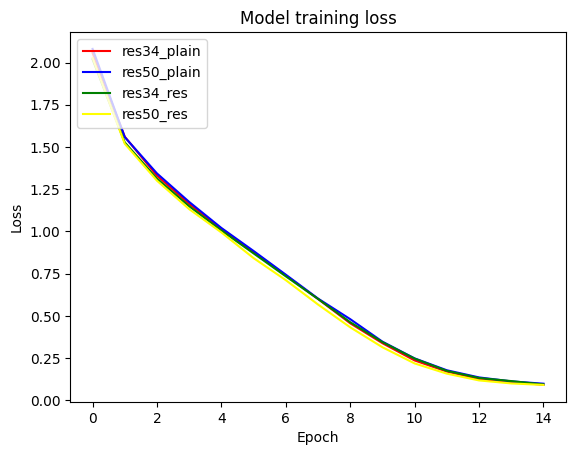

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_34_plain.history['loss'], 'red')
plt.plot(history_50_plain.history['loss'], 'blue')
plt.plot(history_34_res.history['loss'], 'green')
plt.plot(history_50_res.history['loss'], 'yellow')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res34_plain', 'res50_plain', 'res34_res', 'res50_res'], loc='upper left')
plt.show()

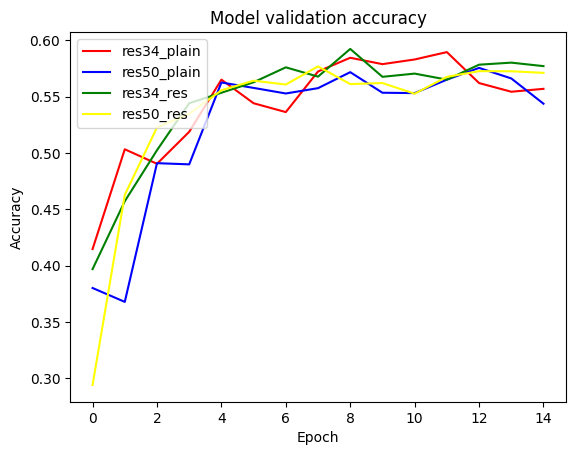

In [25]:
plt.plot(history_34_plain.history['val_accuracy'], 'red')
plt.plot(history_50_plain.history['val_accuracy'], 'blue')
plt.plot(history_34_res.history['val_accuracy'], 'green')
plt.plot(history_50_res.history['val_accuracy'], 'yellow')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['res34_plain', 'res50_plain', 'res34_res', 'res50_res'], loc='upper left')
plt.show()

In [22]:
print("Resnet-34, plain val accuracy :", history_34_plain.history['val_accuracy'][-1])
print("Resnet-50, plain val accuracy :", history_50_plain.history['val_accuracy'][-1])
print("Resnet-34, residual val accuracy :", history_34_res.history['val_accuracy'][-1])
print("Resnet-50, residual val accuracy :", history_50_res.history['val_accuracy'][-1])

Resnet-34, plain val accuracy : 0.5569645762443542
Resnet-50, plain val accuracy : 0.5437700152397156
Resnet-34, residual val accuracy : 0.5771234035491943
Resnet-50, residual val accuracy : 0.5711553692817688


||plain|residual|
|---|---|---|
|Resnet-34|0.557|0.577|
|Resnet-50|0.544|0.571|

위의 표와 같이 residual이 plain에 비해 val accuracy가 높게 나온 것을 알 수 있다.  
또한 plain일 때 Resnet-34보다 Resnet-50이 val accuracy가 더 낮게 나온 것을 알 수 있다.  
역시 lms에서 학습 했던것과 마찬가지로 Vanishing Gradient이 발생하여 일정이상 층을 더 쌓게 되면 오히려 성능이 낮아지는 것을 볼 수 있다.

In [46]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],    
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

def resize_image(image, label):
    image = tf.image.resize(image, [32, 32])
    return image, label

ds_train = ds_train.map(resize_image)
ds_test = ds_test.map(resize_image)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)
print(ds_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/home/gibeom/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon a

In [32]:
resnet_34_plain = build_resnet(input_shape=(32, 32,3), is_50=False, is_plain=True)
resnet_34_plain.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 64)   832         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_68 (BatchN  (None, 16, 16, 64)  256         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_68[0]

In [33]:
resnet_34_res = build_resnet(input_shape=(32, 32,3), is_50=False, is_plain=False)
resnet_34_res.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 16, 16, 64)   832         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_85 (BatchN  (None, 16, 16, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_85[0]

In [34]:
resnet_50_plain = build_resnet(input_shape=(32, 32,3), is_50=True, is_plain=True)
resnet_50_plain.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 16, 16, 64)   832         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_102 (Batch  (None, 16, 16, 64)  256         ['conv2d_24[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_102[0

In [35]:
resnet_50_res = build_resnet(input_shape=(32, 32,3), is_50=True, is_plain=False)
resnet_50_res.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 16, 64)   832         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_119 (Batch  (None, 16, 16, 64)  256         ['conv2d_28[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_119[0

In [54]:
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet_34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps=int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 59/290 [=====>........................] - ETA: 12s - loss: 0.7959 - accuracy: 0.6525

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/290 [=====>........................] - ETA: 12s - loss: 0.7957 - accuracy: 0.6519

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 11s - loss: 0.7945 - accuracy: 0.6519

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 11s - loss: 0.7929 - accuracy: 0.6539

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 5s - loss: 0.7820 - accuracy: 0.6610

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 0.7767 - accuracy: 0.6634

212/290 [====================>.........] - ETA: 4s - loss: 0.7740 - accuracy: 0.6641

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


247/290 [========================>.....] - ETA: 2s - loss: 0.7628 - accuracy: 0.6693

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7594 - accuracy: 0.6680

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 25s 61ms/step - loss: 0.7594 - accuracy: 0.6680 - val_loss: 1.0189 - val_accuracy: 0.6042
Epoch 2/15


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 62/290 [=====>........................] - ETA: 11s - loss: 0.7081 - accuracy: 0.6918

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 11s - loss: 0.7082 - accuracy: 0.6921

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 10s - loss: 0.7051 - accuracy: 0.6917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.7119 - accuracy: 0.6897

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


190/290 [==================>...........] - ETA: 5s - loss: 0.6854 - accuracy: 0.6979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 0.6820 - accuracy: 0.6991

213/290 [=====================>........] - ETA: 3s - loss: 0.6796 - accuracy: 0.6998

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 0.6761 - accuracy: 0.7010

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7050

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.6663 - accuracy: 0.7050 - val_loss: 1.2746 - val_accuracy: 0.5822
Epoch 3/15
 63/290 [=====>........................] - ETA: 11s - loss: 0.5928 - accuracy: 0.7374

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 11s - loss: 0.5870 - accuracy: 0.7394

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 11s - loss: 0.5822 - accuracy: 0.7410

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 10s - loss: 0.5846 - accuracy: 0.7391

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


190/290 [==================>...........] - ETA: 5s - loss: 0.5731 - accuracy: 0.7440

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 4s - loss: 0.5738 - accuracy: 0.7437

213/290 [=====================>........] - ETA: 4s - loss: 0.5715 - accuracy: 0.7443

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.5675 - accuracy: 0.7453

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.7479

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.5606 - accuracy: 0.7479 - val_loss: 0.7234 - val_accuracy: 0.6886
Epoch 4/15


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/290 [=====>........................] - ETA: 11s - loss: 0.4887 - accuracy: 0.7756

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 11s - loss: 0.4866 - accuracy: 0.7770

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 11s - loss: 0.4889 - accuracy: 0.7773

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 10s - loss: 0.4827 - accuracy: 0.7825

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 5s - loss: 0.4777 - accuracy: 0.7905

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 0.4764 - accuracy: 0.7917

214/290 [=====================>........] - ETA: 4s - loss: 0.4739 - accuracy: 0.7926

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.4642 - accuracy: 0.7954

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.4559 - accuracy: 0.7995

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 60ms/step - loss: 0.4553 - accuracy: 0.7998 - val_loss: 0.7861 - val_accuracy: 0.6847
Epoch 5/15
 65/290 [=====>........................] - ETA: 11s - loss: 0.3961 - accuracy: 0.8232

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 11s - loss: 0.4013 - accuracy: 0.8201

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 11s - loss: 0.4068 - accuracy: 0.8181

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 10s - loss: 0.4051 - accuracy: 0.8208

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 4s - loss: 0.3911 - accuracy: 0.8320

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 0.3906 - accuracy: 0.8320

214/290 [=====================>........] - ETA: 3s - loss: 0.3922 - accuracy: 0.8317

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.3802 - accuracy: 0.8367

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.8380

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.3774 - accuracy: 0.8380 - val_loss: 1.0454 - val_accuracy: 0.6333


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 6/15
 64/290 [=====>........................] - ETA: 11s - loss: 0.3404 - accuracy: 0.8481

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 11s - loss: 0.3393 - accuracy: 0.8490

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.3422 - accuracy: 0.8489

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 10s - loss: 0.3367 - accuracy: 0.8528

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 4s - loss: 0.3237 - accuracy: 0.8642

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 0.3190 - accuracy: 0.8656

217/290 [=====================>........] - ETA: 3s - loss: 0.3156 - accuracy: 0.8674

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 0.3104 - accuracy: 0.8684

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.8696

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.3091 - accuracy: 0.8696 - val_loss: 0.9690 - val_accuracy: 0.6809
Epoch 7/15
 65/290 [=====>........................] - ETA: 11s - loss: 0.2780 - accuracy: 0.8887

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 11s - loss: 0.2784 - accuracy: 0.8885

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 11s - loss: 0.2796 - accuracy: 0.8886

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 10s - loss: 0.2776 - accuracy: 0.8905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 4s - loss: 0.2634 - accuracy: 0.8943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.2568 - accuracy: 0.8976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.2495 - accuracy: 0.8993

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9003

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 60ms/step - loss: 0.2461 - accuracy: 0.9003 - val_loss: 1.1643 - val_accuracy: 0.6735
Epoch 8/15
 68/290 [======>.......................] - ETA: 11s - loss: 0.2015 - accuracy: 0.9249

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 10s - loss: 0.2023 - accuracy: 0.9242

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 10s - loss: 0.2040 - accuracy: 0.9233

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 10s - loss: 0.2035 - accuracy: 0.9243

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 4s - loss: 0.2039 - accuracy: 0.9213

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.2041 - accuracy: 0.9205

219/290 [=====================>........] - ETA: 3s - loss: 0.2032 - accuracy: 0.9207

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.1987 - accuracy: 0.9220

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1980 - accuracy: 0.9220

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 58ms/step - loss: 0.1983 - accuracy: 0.9219 - val_loss: 1.0980 - val_accuracy: 0.6933
Epoch 9/15


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 11s - loss: 0.1708 - accuracy: 0.9287

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 10s - loss: 0.1687 - accuracy: 0.9292

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 10s - loss: 0.1662 - accuracy: 0.9302

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 10s - loss: 0.1661 - accuracy: 0.9317

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 4s - loss: 0.1694 - accuracy: 0.9334

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.1714 - accuracy: 0.9321

219/290 [=====================>........] - ETA: 3s - loss: 0.1693 - accuracy: 0.9331

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.1671 - accuracy: 0.9343

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9338

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.1672 - accuracy: 0.9338 - val_loss: 1.1787 - val_accuracy: 0.6821
Epoch 10/15


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 10s - loss: 0.1601 - accuracy: 0.9420

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.1588 - accuracy: 0.9424

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 10s - loss: 0.1602 - accuracy: 0.9412

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 9s - loss: 0.1549 - accuracy: 0.9416 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 0.1479 - accuracy: 0.9435

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.1482 - accuracy: 0.9430

220/290 [=====================>........] - ETA: 3s - loss: 0.1472 - accuracy: 0.9434

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.1483 - accuracy: 0.9434

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9445

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 60ms/step - loss: 0.1458 - accuracy: 0.9444 - val_loss: 1.2751 - val_accuracy: 0.6864
Epoch 11/15
 71/290 [======>.......................] - ETA: 10s - loss: 0.1264 - accuracy: 0.9525

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.1237 - accuracy: 0.9533

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 10s - loss: 0.1213 - accuracy: 0.9543

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 9s - loss: 0.1227 - accuracy: 0.9541

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 0.1220 - accuracy: 0.9532

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.1214 - accuracy: 0.9538

220/290 [=====================>........] - ETA: 3s - loss: 0.1212 - accuracy: 0.9536

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.1184 - accuracy: 0.9548

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9544

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 61ms/step - loss: 0.1195 - accuracy: 0.9544 - val_loss: 1.4868 - val_accuracy: 0.6759
Epoch 12/15
 72/290 [======>.......................] - ETA: 12s - loss: 0.1201 - accuracy: 0.9575

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 11s - loss: 0.1184 - accuracy: 0.9576

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 11s - loss: 0.1144 - accuracy: 0.9585

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 10s - loss: 0.1134 - accuracy: 0.9586

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 4s - loss: 0.1178 - accuracy: 0.9576

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.1152 - accuracy: 0.9582

222/290 [=====================>........] - ETA: 3s - loss: 0.1149 - accuracy: 0.9585

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.1141 - accuracy: 0.9592

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9596

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 62ms/step - loss: 0.1123 - accuracy: 0.9596 - val_loss: 1.7757 - val_accuracy: 0.6698
Epoch 13/15
 73/290 [======>.......................] - ETA: 10s - loss: 0.1021 - accuracy: 0.9619

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.1046 - accuracy: 0.9610

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 10s - loss: 0.1035 - accuracy: 0.9613

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 9s - loss: 0.1064 - accuracy: 0.9604

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.1049 - accuracy: 0.9613

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.1036 - accuracy: 0.9614

225/290 [======================>.......] - ETA: 3s - loss: 0.1052 - accuracy: 0.9609

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.1039 - accuracy: 0.9613

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9606

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 60ms/step - loss: 0.1068 - accuracy: 0.9606 - val_loss: 1.6509 - val_accuracy: 0.6773
Epoch 14/15
 75/290 [======>.......................] - ETA: 10s - loss: 0.1066 - accuracy: 0.9629

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.1079 - accuracy: 0.9624

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 10s - loss: 0.1045 - accuracy: 0.9636

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 9s - loss: 0.1089 - accuracy: 0.9619

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.1081 - accuracy: 0.9612

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.1064 - accuracy: 0.9613

224/290 [======================>.......] - ETA: 3s - loss: 0.1059 - accuracy: 0.9616

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.1036 - accuracy: 0.9618

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1026 - accuracy: 0.9624

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 58ms/step - loss: 0.1029 - accuracy: 0.9623 - val_loss: 2.4502 - val_accuracy: 0.6400
Epoch 15/15
 75/290 [======>.......................] - ETA: 11s - loss: 0.0809 - accuracy: 0.9672

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 0.0831 - accuracy: 0.9673

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 10s - loss: 0.0836 - accuracy: 0.9674

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 9s - loss: 0.0872 - accuracy: 0.9670

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 0.0891 - accuracy: 0.9655

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.0906 - accuracy: 0.9650

226/290 [======================>.......] - ETA: 3s - loss: 0.0899 - accuracy: 0.9655

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.0858 - accuracy: 0.9669

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9664

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.0863 - accuracy: 0.9664 - val_loss: 1.6090 - val_accuracy: 0.6763


In [56]:
resnet_34_res.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_res = resnet_34_res.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps=int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 58/290 [=====>........................] - ETA: 12s - loss: 1.7969 - accuracy: 0.4987

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/290 [=====>........................] - ETA: 12s - loss: 1.7773 - accuracy: 0.5002

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 11s - loss: 1.7260 - accuracy: 0.5061

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 10s - loss: 1.6751 - accuracy: 0.5092

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 5s - loss: 1.4202 - accuracy: 0.5377

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 1.4001 - accuracy: 0.5426

211/290 [====================>.........] - ETA: 4s - loss: 1.3937 - accuracy: 0.5435

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 1.3478 - accuracy: 0.5494

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 1.3077 - accuracy: 0.5558

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 25s 60ms/step - loss: 1.3077 - accuracy: 0.5558 - val_loss: 2.0004 - val_accuracy: 0.4867
Epoch 2/15


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 61/290 [=====>........................] - ETA: 10s - loss: 1.0615 - accuracy: 0.5848

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 10s - loss: 1.0632 - accuracy: 0.5841

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 10s - loss: 1.0543 - accuracy: 0.5861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 9s - loss: 1.0446 - accuracy: 0.5891

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 4s - loss: 1.0024 - accuracy: 0.6016

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 0.9930 - accuracy: 0.6020

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 1s - loss: 0.9823 - accuracy: 0.6047

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.9697 - accuracy: 0.6080

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 16s 57ms/step - loss: 0.9697 - accuracy: 0.6080 - val_loss: 1.1285 - val_accuracy: 0.5406


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 3/15
 63/290 [=====>........................] - ETA: 10s - loss: 0.8707 - accuracy: 0.6361

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 10s - loss: 0.8614 - accuracy: 0.6372

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.8544 - accuracy: 0.6412

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 9s - loss: 0.8575 - accuracy: 0.6397

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 4s - loss: 0.8220 - accuracy: 0.6485

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 4s - loss: 0.8186 - accuracy: 0.6503

213/290 [=====================>........] - ETA: 3s - loss: 0.8132 - accuracy: 0.6506

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 1s - loss: 0.8057 - accuracy: 0.6533

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7974 - accuracy: 0.6545

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 16s 57ms/step - loss: 0.7974 - accuracy: 0.6545 - val_loss: 0.9074 - val_accuracy: 0.6233
Epoch 4/15
 65/290 [=====>........................] - ETA: 11s - loss: 0.7052 - accuracy: 0.6822

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 11s - loss: 0.7055 - accuracy: 0.6814

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 10s - loss: 0.7029 - accuracy: 0.6825

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 9s - loss: 0.6925 - accuracy: 0.6878 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 4s - loss: 0.6820 - accuracy: 0.6969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 0.6850 - accuracy: 0.6949

214/290 [=====================>........] - ETA: 3s - loss: 0.6854 - accuracy: 0.6948

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 1s - loss: 0.6754 - accuracy: 0.6987

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.7006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 57ms/step - loss: 0.6692 - accuracy: 0.7006 - val_loss: 0.8235 - val_accuracy: 0.6484
Epoch 5/15


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/290 [=====>........................] - ETA: 11s - loss: 0.6182 - accuracy: 0.7239

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 10s - loss: 0.6153 - accuracy: 0.7246

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 10s - loss: 0.6124 - accuracy: 0.7256

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 9s - loss: 0.6154 - accuracy: 0.7238 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 4s - loss: 0.6034 - accuracy: 0.7285

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.6020 - accuracy: 0.7288

215/290 [=====================>........] - ETA: 3s - loss: 0.6008 - accuracy: 0.7294

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.5946 - accuracy: 0.7318

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.5910 - accuracy: 0.7343

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 58ms/step - loss: 0.5902 - accuracy: 0.7346 - val_loss: 0.8212 - val_accuracy: 0.6534


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 6/15
 66/290 [=====>........................] - ETA: 11s - loss: 0.4959 - accuracy: 0.7741

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 10s - loss: 0.5013 - accuracy: 0.7725

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 10s - loss: 0.5019 - accuracy: 0.7740

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 9s - loss: 0.4949 - accuracy: 0.7757

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 4s - loss: 0.4945 - accuracy: 0.7750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.4988 - accuracy: 0.7745

216/290 [=====================>........] - ETA: 3s - loss: 0.4995 - accuracy: 0.7746

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.4883 - accuracy: 0.7801

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.7847

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 57ms/step - loss: 0.4779 - accuracy: 0.7847 - val_loss: 0.9852 - val_accuracy: 0.6386
Epoch 7/15
 67/290 [=====>........................] - ETA: 11s - loss: 0.4093 - accuracy: 0.8183

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 11s - loss: 0.4072 - accuracy: 0.8202

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 0.4079 - accuracy: 0.8197

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 10s - loss: 0.4075 - accuracy: 0.8196

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 4s - loss: 0.4105 - accuracy: 0.8188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 4s - loss: 0.4093 - accuracy: 0.8196

218/290 [=====================>........] - ETA: 3s - loss: 0.4079 - accuracy: 0.8209

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.4004 - accuracy: 0.8236

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.3936 - accuracy: 0.8267

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.3940 - accuracy: 0.8265 - val_loss: 0.9705 - val_accuracy: 0.6620


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 8/15
 67/290 [=====>........................] - ETA: 10s - loss: 0.3397 - accuracy: 0.8570

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 10s - loss: 0.3383 - accuracy: 0.8562

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.3396 - accuracy: 0.8574

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.3456 - accuracy: 0.8551

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 4s - loss: 0.3328 - accuracy: 0.8574

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.3306 - accuracy: 0.8580

219/290 [=====================>........] - ETA: 3s - loss: 0.3291 - accuracy: 0.8591

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.3248 - accuracy: 0.8627

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8646

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 16s 57ms/step - loss: 0.3216 - accuracy: 0.8646 - val_loss: 1.2460 - val_accuracy: 0.6341
Epoch 9/15
 68/290 [======>.......................] - ETA: 10s - loss: 0.2607 - accuracy: 0.8941

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.2544 - accuracy: 0.8966

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.2517 - accuracy: 0.8981

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 9s - loss: 0.2574 - accuracy: 0.8959

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 4s - loss: 0.2534 - accuracy: 0.8955

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.2497 - accuracy: 0.8966

219/290 [=====================>........] - ETA: 3s - loss: 0.2481 - accuracy: 0.8976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.2479 - accuracy: 0.8979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.8979

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 16s 56ms/step - loss: 0.2481 - accuracy: 0.8979 - val_loss: 1.0589 - val_accuracy: 0.6717
Epoch 10/15
 70/290 [======>.......................] - ETA: 10s - loss: 0.2148 - accuracy: 0.9147

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.2110 - accuracy: 0.9155

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.2030 - accuracy: 0.9165

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 4s - loss: 0.2028 - accuracy: 0.9167

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.2049 - accuracy: 0.9158

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.1999 - accuracy: 0.9183

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.9184

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 58ms/step - loss: 0.1995 - accuracy: 0.9184 - val_loss: 1.3981 - val_accuracy: 0.6587
Epoch 11/15
 70/290 [======>.......................] - ETA: 11s - loss: 0.1798 - accuracy: 0.9272

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 10s - loss: 0.1792 - accuracy: 0.9271

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 10s - loss: 0.1831 - accuracy: 0.9268

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 9s - loss: 0.1789 - accuracy: 0.9289

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 0.1646 - accuracy: 0.9364

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.1649 - accuracy: 0.9359

222/290 [=====================>........] - ETA: 3s - loss: 0.1628 - accuracy: 0.9363

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.1598 - accuracy: 0.9374

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9379

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.1599 - accuracy: 0.9379 - val_loss: 1.2836 - val_accuracy: 0.6833
Epoch 12/15
 72/290 [======>.......................] - ETA: 10s - loss: 0.1369 - accuracy: 0.9458

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 10s - loss: 0.1363 - accuracy: 0.9464

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 10s - loss: 0.1403 - accuracy: 0.9441

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 9s - loss: 0.1416 - accuracy: 0.9437

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 4s - loss: 0.1398 - accuracy: 0.9447

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.1373 - accuracy: 0.9457

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.1375 - accuracy: 0.9462

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.9462

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 60ms/step - loss: 0.1372 - accuracy: 0.9463 - val_loss: 1.6152 - val_accuracy: 0.6541
Epoch 13/15
 74/290 [======>.......................] - ETA: 10s - loss: 0.1210 - accuracy: 0.9552

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 9s - loss: 0.1189 - accuracy: 0.9561 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 9s - loss: 0.1208 - accuracy: 0.9565

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 9s - loss: 0.1184 - accuracy: 0.9571

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.1241 - accuracy: 0.9535

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.1230 - accuracy: 0.9541

224/290 [======================>.......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9542

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.1201 - accuracy: 0.9549

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9549

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 57ms/step - loss: 0.1213 - accuracy: 0.9548 - val_loss: 1.4015 - val_accuracy: 0.6884
Epoch 14/15
 73/290 [======>.......................] - ETA: 11s - loss: 0.1214 - accuracy: 0.9538

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.1216 - accuracy: 0.9537

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 10s - loss: 0.1256 - accuracy: 0.9522

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 10s - loss: 0.1187 - accuracy: 0.9549

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 4s - loss: 0.1164 - accuracy: 0.9559

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.1157 - accuracy: 0.9561

225/290 [======================>.......] - ETA: 3s - loss: 0.1170 - accuracy: 0.9556

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.1140 - accuracy: 0.9569

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9579

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 63ms/step - loss: 0.1127 - accuracy: 0.9579 - val_loss: 1.5741 - val_accuracy: 0.6763
Epoch 15/15
 73/290 [======>.......................] - ETA: 12s - loss: 0.1147 - accuracy: 0.9551

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 11s - loss: 0.1194 - accuracy: 0.9534

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 11s - loss: 0.1187 - accuracy: 0.9537

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 10s - loss: 0.1200 - accuracy: 0.9538

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.1068 - accuracy: 0.9591

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.1067 - accuracy: 0.9591

225/290 [======================>.......] - ETA: 3s - loss: 0.1061 - accuracy: 0.9592

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.1082 - accuracy: 0.9583

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9584

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 62ms/step - loss: 0.1073 - accuracy: 0.9584 - val_loss: 1.5170 - val_accuracy: 0.6832


In [57]:
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet_50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps=int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 59/290 [=====>........................] - ETA: 12s - loss: 1.8885 - accuracy: 0.5098

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 65/290 [=====>........................] - ETA: 11s - loss: 1.8488 - accuracy: 0.5123

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 11s - loss: 1.8131 - accuracy: 0.5165

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 10s - loss: 1.7312 - accuracy: 0.5243

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 5s - loss: 1.4757 - accuracy: 0.5486

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 4s - loss: 1.4422 - accuracy: 0.5533

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 1.4029 - accuracy: 0.5557

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 1.3690 - accuracy: 0.5591

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 26s 63ms/step - loss: 1.3690 - accuracy: 0.5591 - val_loss: 0.7614 - val_accuracy: 0.5234
Epoch 2/15
 62/290 [=====>........................] - ETA: 12s - loss: 1.0817 - accuracy: 0.5794

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/290 [=====>........................] - ETA: 12s - loss: 1.0928 - accuracy: 0.5765

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 11s - loss: 1.0937 - accuracy: 0.5813

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 11s - loss: 1.0892 - accuracy: 0.5799

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 5s - loss: 1.0430 - accuracy: 0.5933

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 1.0360 - accuracy: 0.5929

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 1.0170 - accuracy: 0.5972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.9899 - accuracy: 0.6040

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 63ms/step - loss: 0.9899 - accuracy: 0.6040 - val_loss: 0.7098 - val_accuracy: 0.6421
Epoch 3/15
 63/290 [=====>........................] - ETA: 11s - loss: 0.8749 - accuracy: 0.6399

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 11s - loss: 0.8773 - accuracy: 0.6392

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 10s - loss: 0.8721 - accuracy: 0.6415

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.8624 - accuracy: 0.6450

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 5s - loss: 0.8352 - accuracy: 0.6466

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 0.8298 - accuracy: 0.6482

213/290 [=====================>........] - ETA: 4s - loss: 0.8277 - accuracy: 0.6483

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.8201 - accuracy: 0.6503

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.8043 - accuracy: 0.6550

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 63ms/step - loss: 0.8043 - accuracy: 0.6550 - val_loss: 0.8840 - val_accuracy: 0.6254
Epoch 4/15
 63/290 [=====>........................] - ETA: 11s - loss: 0.7252 - accuracy: 0.6860

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 11s - loss: 0.7208 - accuracy: 0.6839

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.7148 - accuracy: 0.6859

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 10s - loss: 0.7147 - accuracy: 0.6826

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 5s - loss: 0.7005 - accuracy: 0.6891

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 0.6912 - accuracy: 0.6925

213/290 [=====================>........] - ETA: 4s - loss: 0.6904 - accuracy: 0.6931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.6876 - accuracy: 0.6943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.6972

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 61ms/step - loss: 0.6809 - accuracy: 0.6972 - val_loss: 0.7605 - val_accuracy: 0.6606
Epoch 5/15
 65/290 [=====>........................] - ETA: 11s - loss: 0.6166 - accuracy: 0.7217

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 11s - loss: 0.6172 - accuracy: 0.7201

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 10s - loss: 0.6151 - accuracy: 0.7232

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 10s - loss: 0.6150 - accuracy: 0.7238

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 4s - loss: 0.5885 - accuracy: 0.7382

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.5802 - accuracy: 0.7428

215/290 [=====================>........] - ETA: 3s - loss: 0.5787 - accuracy: 0.7437

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.5719 - accuracy: 0.7465

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.7473

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 60ms/step - loss: 0.5703 - accuracy: 0.7473 - val_loss: 0.7408 - val_accuracy: 0.6730
Epoch 6/15
 66/290 [=====>........................] - ETA: 11s - loss: 0.5486 - accuracy: 0.7563

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 11s - loss: 0.5476 - accuracy: 0.7540

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.5449 - accuracy: 0.7557

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 10s - loss: 0.5296 - accuracy: 0.7631

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 4s - loss: 0.5080 - accuracy: 0.7727

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 4s - loss: 0.5074 - accuracy: 0.7731

216/290 [=====================>........] - ETA: 3s - loss: 0.5025 - accuracy: 0.7749

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.4939 - accuracy: 0.7775

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.7802

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.4857 - accuracy: 0.7802 - val_loss: 0.7388 - val_accuracy: 0.6811
Epoch 7/15
 67/290 [=====>........................] - ETA: 11s - loss: 0.4426 - accuracy: 0.8095

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 10s - loss: 0.4410 - accuracy: 0.8096

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 10s - loss: 0.4416 - accuracy: 0.8091

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 9s - loss: 0.4405 - accuracy: 0.8083 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 4s - loss: 0.4234 - accuracy: 0.8166

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.4190 - accuracy: 0.8177

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.4193 - accuracy: 0.8194

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8238

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.4081 - accuracy: 0.8236 - val_loss: 0.9701 - val_accuracy: 0.6593
Epoch 8/15
 66/290 [=====>........................] - ETA: 10s - loss: 0.3216 - accuracy: 0.8662

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 10s - loss: 0.3237 - accuracy: 0.8658

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 0.3198 - accuracy: 0.8676

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 9s - loss: 0.3187 - accuracy: 0.8688

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 4s - loss: 0.3128 - accuracy: 0.8707

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.3110 - accuracy: 0.8718

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.3114 - accuracy: 0.8713

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.3084 - accuracy: 0.8728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 58ms/step - loss: 0.3083 - accuracy: 0.8726 - val_loss: 1.5044 - val_accuracy: 0.6212
Epoch 9/15
 70/290 [======>.......................] - ETA: 11s - loss: 0.2865 - accuracy: 0.8844

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 11s - loss: 0.2846 - accuracy: 0.8850

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 0.2784 - accuracy: 0.8880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 9s - loss: 0.2763 - accuracy: 0.8873 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 4s - loss: 0.2636 - accuracy: 0.8916

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.2658 - accuracy: 0.8907

220/290 [=====================>........] - ETA: 3s - loss: 0.2638 - accuracy: 0.8914

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.2589 - accuracy: 0.8936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.8949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.2564 - accuracy: 0.8949 - val_loss: 1.0424 - val_accuracy: 0.6890
Epoch 10/15
 70/290 [======>.......................] - ETA: 11s - loss: 0.2199 - accuracy: 0.9116

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.2240 - accuracy: 0.9095

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 0.2241 - accuracy: 0.9095

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 9s - loss: 0.2248 - accuracy: 0.9086

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 4s - loss: 0.2078 - accuracy: 0.9168

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.2076 - accuracy: 0.9162

220/290 [=====================>........] - ETA: 3s - loss: 0.2067 - accuracy: 0.9167

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.2052 - accuracy: 0.9167

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9174

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.2042 - accuracy: 0.9174 - val_loss: 1.2117 - val_accuracy: 0.6678
Epoch 11/15
 69/290 [======>.......................] - ETA: 10s - loss: 0.1734 - accuracy: 0.9303

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 10s - loss: 0.1756 - accuracy: 0.9308

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 10s - loss: 0.1743 - accuracy: 0.9312

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 9s - loss: 0.1739 - accuracy: 0.9309

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 4s - loss: 0.1729 - accuracy: 0.9300

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.1703 - accuracy: 0.9313

222/290 [=====================>........] - ETA: 3s - loss: 0.1702 - accuracy: 0.9315

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.1695 - accuracy: 0.9320

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9330

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 60ms/step - loss: 0.1676 - accuracy: 0.9330 - val_loss: 1.8279 - val_accuracy: 0.6398
Epoch 12/15
 71/290 [======>.......................] - ETA: 11s - loss: 0.1537 - accuracy: 0.9390

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 11s - loss: 0.1510 - accuracy: 0.9399

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 11s - loss: 0.1515 - accuracy: 0.9398

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 10s - loss: 0.1511 - accuracy: 0.9408

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 4s - loss: 0.1517 - accuracy: 0.9401

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 4s - loss: 0.1529 - accuracy: 0.9396

223/290 [======================>.......] - ETA: 3s - loss: 0.1513 - accuracy: 0.9400

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.1447 - accuracy: 0.9429

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9430

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 61ms/step - loss: 0.1447 - accuracy: 0.9430 - val_loss: 1.2998 - val_accuracy: 0.6951
Epoch 13/15
 73/290 [======>.......................] - ETA: 11s - loss: 0.1568 - accuracy: 0.9403

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 11s - loss: 0.1558 - accuracy: 0.9411

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 10s - loss: 0.1532 - accuracy: 0.9423

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 10s - loss: 0.1495 - accuracy: 0.9442

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.1360 - accuracy: 0.9495

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.1359 - accuracy: 0.9493

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.1333 - accuracy: 0.9501

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1304 - accuracy: 0.9512

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 60ms/step - loss: 0.1302 - accuracy: 0.9513 - val_loss: 1.4484 - val_accuracy: 0.6724
Epoch 14/15
 74/290 [======>.......................] - ETA: 11s - loss: 0.1185 - accuracy: 0.9533

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 0.1217 - accuracy: 0.9523

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.1224 - accuracy: 0.9529

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 9s - loss: 0.1202 - accuracy: 0.9547

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 4s - loss: 0.1196 - accuracy: 0.9540

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.1175 - accuracy: 0.9545

225/290 [======================>.......] - ETA: 3s - loss: 0.1164 - accuracy: 0.9551

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.1144 - accuracy: 0.9556

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9552

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 62ms/step - loss: 0.1159 - accuracy: 0.9552 - val_loss: 1.4476 - val_accuracy: 0.6992
Epoch 15/15
 75/290 [======>.......................] - ETA: 11s - loss: 0.1187 - accuracy: 0.9550

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 11s - loss: 0.1156 - accuracy: 0.9558

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 11s - loss: 0.1160 - accuracy: 0.9560

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 10s - loss: 0.1183 - accuracy: 0.9544

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 4s - loss: 0.1075 - accuracy: 0.9598

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.1089 - accuracy: 0.9591

227/290 [======================>.......] - ETA: 3s - loss: 0.1078 - accuracy: 0.9593

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.1081 - accuracy: 0.9596

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9593

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 63ms/step - loss: 0.1091 - accuracy: 0.9593 - val_loss: 1.4116 - val_accuracy: 0.6953


In [58]:
resnet_50_res.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_res = resnet_50_res.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps=int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 60/290 [=====>........................] - ETA: 13s - loss: 1.8236 - accuracy: 0.5104

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 66/290 [=====>........................] - ETA: 12s - loss: 1.7980 - accuracy: 0.5123

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 12s - loss: 1.7798 - accuracy: 0.5125

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 11s - loss: 1.7151 - accuracy: 0.5202

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


190/290 [==================>...........] - ETA: 5s - loss: 1.5116 - accuracy: 0.5442

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 4s - loss: 1.4914 - accuracy: 0.5464

211/290 [====================>.........] - ETA: 4s - loss: 1.4851 - accuracy: 0.5468

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


246/290 [========================>.....] - ETA: 2s - loss: 1.4458 - accuracy: 0.5502

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 1.4024 - accuracy: 0.5569

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 26s 62ms/step - loss: 1.4024 - accuracy: 0.5569 - val_loss: 1.5294 - val_accuracy: 0.4950
Epoch 2/15
 63/290 [=====>........................] - ETA: 11s - loss: 1.1917 - accuracy: 0.5734

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 11s - loss: 1.1837 - accuracy: 0.5734

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 11s - loss: 1.1843 - accuracy: 0.5734

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 10s - loss: 1.1789 - accuracy: 0.5767

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


190/290 [==================>...........] - ETA: 5s - loss: 1.0954 - accuracy: 0.5931

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 4s - loss: 1.0835 - accuracy: 0.5958

214/290 [=====================>........] - ETA: 3s - loss: 1.0779 - accuracy: 0.5974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 1.0583 - accuracy: 0.6021

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 1.0448 - accuracy: 0.6052

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 61ms/step - loss: 1.0448 - accuracy: 0.6052 - val_loss: 1.1036 - val_accuracy: 0.5551
Epoch 3/15
 63/290 [=====>........................] - ETA: 11s - loss: 0.9386 - accuracy: 0.6208

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 11s - loss: 0.9244 - accuracy: 0.6227

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 11s - loss: 0.9282 - accuracy: 0.6227

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 0.9099 - accuracy: 0.6294

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 5s - loss: 0.8950 - accuracy: 0.6319

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 4s - loss: 0.8882 - accuracy: 0.6338

212/290 [====================>.........] - ETA: 4s - loss: 0.8839 - accuracy: 0.6348

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.8713 - accuracy: 0.6386

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.8641 - accuracy: 0.6412

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 61ms/step - loss: 0.8641 - accuracy: 0.6412 - val_loss: 0.9418 - val_accuracy: 0.6295
Epoch 4/15
 64/290 [=====>........................] - ETA: 11s - loss: 0.7717 - accuracy: 0.6755

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 11s - loss: 0.7688 - accuracy: 0.6762

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 11s - loss: 0.7675 - accuracy: 0.6745

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 10s - loss: 0.7560 - accuracy: 0.6780

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 4s - loss: 0.7197 - accuracy: 0.6909

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 0.7207 - accuracy: 0.6902

214/290 [=====================>........] - ETA: 3s - loss: 0.7196 - accuracy: 0.6910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 1s - loss: 0.7126 - accuracy: 0.6936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.7043 - accuracy: 0.6970

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 61ms/step - loss: 0.7039 - accuracy: 0.6970 - val_loss: 0.8024 - val_accuracy: 0.6497
Epoch 5/15
 64/290 [=====>........................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6987

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 11s - loss: 0.6578 - accuracy: 0.7002

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 11s - loss: 0.6546 - accuracy: 0.7002

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 10s - loss: 0.6301 - accuracy: 0.7108

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 5s - loss: 0.6081 - accuracy: 0.7265

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.6054 - accuracy: 0.7287

215/290 [=====================>........] - ETA: 3s - loss: 0.6057 - accuracy: 0.7288

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.5973 - accuracy: 0.7333

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.7356

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 62ms/step - loss: 0.5927 - accuracy: 0.7356 - val_loss: 0.9520 - val_accuracy: 0.6204
Epoch 6/15
 65/290 [=====>........................] - ETA: 12s - loss: 0.5569 - accuracy: 0.7510

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 12s - loss: 0.5567 - accuracy: 0.7507

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 12s - loss: 0.5580 - accuracy: 0.7494

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 11s - loss: 0.5566 - accuracy: 0.7503

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 5s - loss: 0.5341 - accuracy: 0.7590

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 0.5330 - accuracy: 0.7597

218/290 [=====================>........] - ETA: 3s - loss: 0.5311 - accuracy: 0.7602

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.5227 - accuracy: 0.7636

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.7693

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 62ms/step - loss: 0.5108 - accuracy: 0.7693 - val_loss: 0.9023 - val_accuracy: 0.6580
Epoch 7/15
 67/290 [=====>........................] - ETA: 11s - loss: 0.4558 - accuracy: 0.8004

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 10s - loss: 0.4527 - accuracy: 0.8016

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 0.4449 - accuracy: 0.8049

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.4363 - accuracy: 0.8081 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 4s - loss: 0.4064 - accuracy: 0.8209

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.4046 - accuracy: 0.8217

216/290 [=====================>........] - ETA: 3s - loss: 0.4030 - accuracy: 0.8220

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 0.4039 - accuracy: 0.8239

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8257

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.4005 - accuracy: 0.8257 - val_loss: 0.8486 - val_accuracy: 0.6694
Epoch 8/15
 68/290 [======>.......................] - ETA: 12s - loss: 0.3584 - accuracy: 0.8469

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 11s - loss: 0.3544 - accuracy: 0.8484

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 11s - loss: 0.3597 - accuracy: 0.8455

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 10s - loss: 0.3587 - accuracy: 0.8452

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 5s - loss: 0.3443 - accuracy: 0.8521

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 4s - loss: 0.3435 - accuracy: 0.8534

218/290 [=====================>........] - ETA: 3s - loss: 0.3428 - accuracy: 0.8537

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.3394 - accuracy: 0.8555

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.8588

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 63ms/step - loss: 0.3333 - accuracy: 0.8588 - val_loss: 1.0041 - val_accuracy: 0.6755
Epoch 9/15
 69/290 [======>.......................] - ETA: 11s - loss: 0.2735 - accuracy: 0.8862

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 11s - loss: 0.2790 - accuracy: 0.8836

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 0.2763 - accuracy: 0.8840

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 10s - loss: 0.2722 - accuracy: 0.8859

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 4s - loss: 0.2595 - accuracy: 0.8931

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.2544 - accuracy: 0.8954

219/290 [=====================>........] - ETA: 3s - loss: 0.2547 - accuracy: 0.8951

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.2511 - accuracy: 0.8975

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.2475 - accuracy: 0.8991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.2472 - accuracy: 0.8993 - val_loss: 1.3196 - val_accuracy: 0.6607
Epoch 10/15
 70/290 [======>.......................] - ETA: 11s - loss: 0.2168 - accuracy: 0.9129

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 11s - loss: 0.2190 - accuracy: 0.9119

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 0.2148 - accuracy: 0.9133

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 10s - loss: 0.2142 - accuracy: 0.9131

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 4s - loss: 0.1986 - accuracy: 0.9200

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 4s - loss: 0.1984 - accuracy: 0.9201

218/290 [=====================>........] - ETA: 3s - loss: 0.1997 - accuracy: 0.9198

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.2000 - accuracy: 0.9192

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9185

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 21s 71ms/step - loss: 0.2016 - accuracy: 0.9185 - val_loss: 1.2261 - val_accuracy: 0.6883
Epoch 11/15
 70/290 [======>.......................] - ETA: 11s - loss: 0.1783 - accuracy: 0.9310

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 11s - loss: 0.1804 - accuracy: 0.9298

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 10s - loss: 0.1805 - accuracy: 0.9294

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 10s - loss: 0.1811 - accuracy: 0.9290

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 4s - loss: 0.1779 - accuracy: 0.9309

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.1750 - accuracy: 0.9319

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.1739 - accuracy: 0.9320

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9329

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 62ms/step - loss: 0.1707 - accuracy: 0.9329 - val_loss: 1.3088 - val_accuracy: 0.6764
Epoch 12/15
 72/290 [======>.......................] - ETA: 11s - loss: 0.1780 - accuracy: 0.9329

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 10s - loss: 0.1795 - accuracy: 0.9326

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 10s - loss: 0.1764 - accuracy: 0.9334

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 9s - loss: 0.1692 - accuracy: 0.9361

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 4s - loss: 0.1595 - accuracy: 0.9387

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.1577 - accuracy: 0.9389

223/290 [======================>.......] - ETA: 3s - loss: 0.1585 - accuracy: 0.9384

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.1529 - accuracy: 0.9402

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9417

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.1491 - accuracy: 0.9417 - val_loss: 1.3720 - val_accuracy: 0.6871
Epoch 13/15
 73/290 [======>.......................] - ETA: 10s - loss: 0.1465 - accuracy: 0.9437

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.1425 - accuracy: 0.9454

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.1420 - accuracy: 0.9457

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 9s - loss: 0.1370 - accuracy: 0.9482

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 4s - loss: 0.1334 - accuracy: 0.9483

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.1310 - accuracy: 0.9494

222/290 [=====================>........] - ETA: 3s - loss: 0.1311 - accuracy: 0.9495

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.1304 - accuracy: 0.9497

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9502

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 59ms/step - loss: 0.1296 - accuracy: 0.9502 - val_loss: 1.4623 - val_accuracy: 0.6760
Epoch 14/15
 73/290 [======>.......................] - ETA: 11s - loss: 0.1041 - accuracy: 0.9598

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 0.1071 - accuracy: 0.9590

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.1064 - accuracy: 0.9595

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 9s - loss: 0.1138 - accuracy: 0.9575

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.1117 - accuracy: 0.9578

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.1102 - accuracy: 0.9578

224/290 [======================>.......] - ETA: 3s - loss: 0.1097 - accuracy: 0.9581

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.1099 - accuracy: 0.9584

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9583

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 17s 60ms/step - loss: 0.1113 - accuracy: 0.9583 - val_loss: 1.4886 - val_accuracy: 0.6782
Epoch 15/15
 74/290 [======>.......................] - ETA: 11s - loss: 0.1097 - accuracy: 0.9584

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 11s - loss: 0.1120 - accuracy: 0.9576

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 10s - loss: 0.1146 - accuracy: 0.9569

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 10s - loss: 0.1135 - accuracy: 0.9565

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 4s - loss: 0.1052 - accuracy: 0.9604

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.1072 - accuracy: 0.9595

224/290 [======================>.......] - ETA: 3s - loss: 0.1072 - accuracy: 0.9594

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.1055 - accuracy: 0.9602

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9601

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


290/290 [==============================] - 18s 60ms/step - loss: 0.1067 - accuracy: 0.9601 - val_loss: 1.5095 - val_accuracy: 0.6970


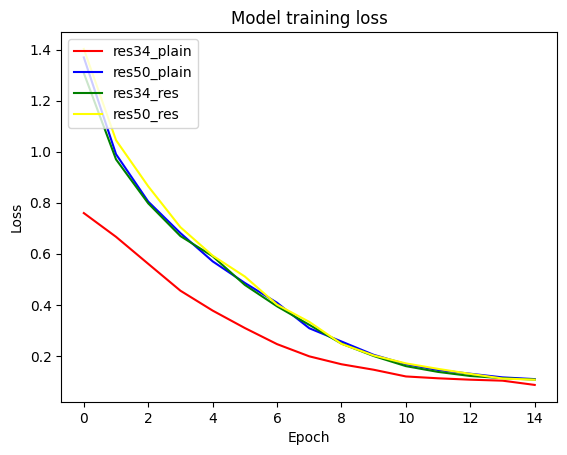

In [59]:
plt.plot(history_34_plain.history['loss'], 'red')
plt.plot(history_50_plain.history['loss'], 'blue')
plt.plot(history_34_res.history['loss'], 'green')
plt.plot(history_50_res.history['loss'], 'yellow')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res34_plain', 'res50_plain', 'res34_res', 'res50_res'], loc='upper left')
plt.show()

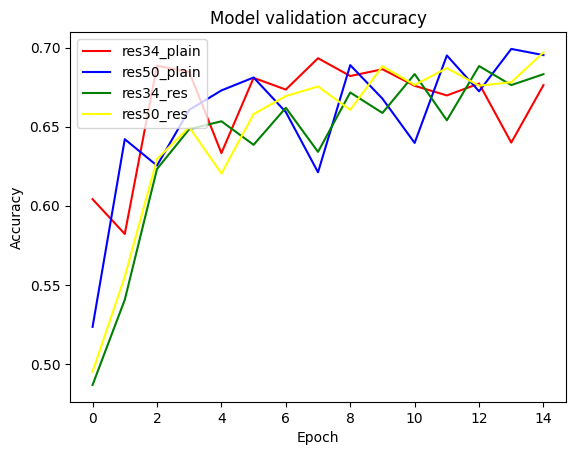

In [60]:
plt.plot(history_34_plain.history['val_accuracy'], 'red')
plt.plot(history_50_plain.history['val_accuracy'], 'blue')
plt.plot(history_34_res.history['val_accuracy'], 'green')
plt.plot(history_50_res.history['val_accuracy'], 'yellow')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['res34_plain', 'res50_plain', 'res34_res', 'res50_res'], loc='upper left')
plt.show()

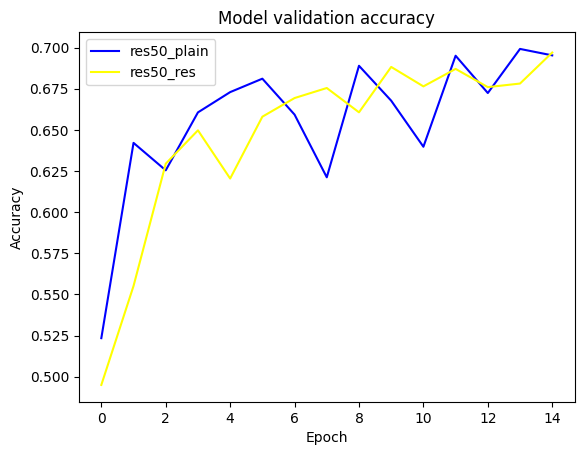

In [62]:
plt.plot(history_50_plain.history['val_accuracy'], 'blue')
plt.plot(history_50_res.history['val_accuracy'], 'yellow')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['res50_plain', 'res50_res'], loc='upper left')
plt.show()

In [61]:
print("Resnet-34, plain val accuracy :", history_34_plain.history['val_accuracy'][-1])
print("Resnet-50, plain val accuracy :", history_50_plain.history['val_accuracy'][-1])
print("Resnet-34, residual val accuracy :", history_34_res.history['val_accuracy'][-1])
print("Resnet-50, residual val accuracy :", history_50_res.history['val_accuracy'][-1])

Resnet-34, plain val accuracy : 0.6763295531272888
Resnet-50, plain val accuracy : 0.695292055606842
Resnet-34, residual val accuracy : 0.6832311749458313
Resnet-50, residual val accuracy : 0.6970227956771851


||plain|residual|
|---|---|---|
|Resnet-34|0.676|0.683|
|Resnet-50|0.695|0.697|

위의 표와 같이 residual이 plain에 비해 val accuracy가 높게 나온 것을 알 수 있다.  
다만 CIFAR10 과는 다르게 Resnet-50에서는 그 결과가 드라마틱한 차이를 보이지는 않는다.  
예상해보기로는 학습 epoch 자체가 부족했던 것으로 추측된다.

res50의 결과만 비교해보면 val accuracy는 계속해서 증가하는 추세인 것을 알 수 있다.  
CIFAR10의 경우에는 15 epoch일 때 이미 정확도는 크게 증가하지 않고 평행선을 그리는 것을 비교해보면 이는 더 두드러진다.  
즉, 15 epoch보다 더 많은 량의 학습을 돌리면 plain과 residual의 accuracy차이는 좀더 벌어질 것으로 예측된다.